## Flexure profile solver for an unfixed grounding line

<b>Translation of the Matlab script into Python</b>

# Section data for ice shelf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from netCDF4 import num2date
# import h5netcdf
import xarray as xr

import geopandas as gpd
import cartopy as cartopy
# from matplotlib import ticker
import cartopy.crs as ccrs
from matplotlib.patheffects import withStroke

from scipy.interpolate import RegularGridInterpolator

from Interp_scripts_main.interp_bedmachine_antarctica import interp_bedmachine_antarctica
from Interp_scripts_main.ll2xy import ll2xy
from Interp_scripts_main.xy2ll import xy2ll

from Outer_solver import Outer_profile_solver

filename = 'Data/BedMachineAntarctica-v3.nc'
xarray_dataset = xr.open_dataset(filename)

vel_filename = '/Volumes/Josh_SSD/Antarctica_velocity_data/ITS_LIVE_velocity_120m_RGI19A_0000_v02.nc'
xarray_vel_dataset = xr.open_dataset(vel_filename)

In [2]:
display(xarray_vel_dataset)
display(xarray_dataset)

<xarray.Dataset> Size: 267GB
Dimensions:          (x: 45834, y: 38334, sensor: 5)
Coordinates:
  * x                (x) float64 367kB -2.7e+06 -2.7e+06 ... 2.8e+06 2.8e+06
  * y                (y) float64 307kB 2.4e+06 2.4e+06 ... -2.2e+06 -2.2e+06
  * sensor           (sensor) object 40B 'L4_L5' 'L7' ... 'S1A_S1B' 'S2A_S2B'
Data variables: (12/25)
    mapping          <U1 4B ...
    dt_max           (sensor, y, x) timedelta64[ns] 70GB ...
    sensor_flag      (sensor, y, x) float32 35GB ...
    count            (y, x) float64 14GB ...
    landice          (y, x) float32 7GB ...
    floatingice      (y, x) float32 7GB ...
    ...               ...
    v_amp_error      (y, x) float32 7GB ...
    vx_amp_error     (y, x) float32 7GB ...
    vy_amp_error     (y, x) float32 7GB ...
    v_phase          (y, x) float32 7GB ...
    vx_phase         (y, x) float32 7GB ...
    vy_phase         (y, x) float32 7GB ...
Attributes: (12/14)
    author:                            ITS_LIVE, a NASA MEaSUREs project (its...
    datacube_autoRIFT_parameter_file:  http://its-live-data.s3.amazonaws.com/...
    institution:                       NASA Jet Propulsion Laboratory (JPL), ...
    region:                            RGI19A
    GDAL_AREA_OR_POINT:                Area
    mosaics_software_version:          1.0
    ...                                ...
    date_created:                      15-Mar-2024 10:41:26
    sensors_labels:                    Band 1: L4_L5; Band 2: L7; Band 3: L8_...
    latitude:                          [-72.84, -84.44, -84.44, -83.53, -83.5...
    longitude:                         [0.6, -174.01, 175.2, -174.87, 175.89,...
    s3:                                s3://its-live-data/mosaics/annual/v2_s...
    url:                               http://its-live-data.s3.amazonaws.com/...

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB ...
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB ...
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [3]:
# centre_of_vel = [-1445000, -874000]

# vel_xmax = centre_of_vel[0] + 3.0e5
# vel_xmin = centre_of_vel[0] - 3.0e5
# vel_ymax = centre_of_vel[1] + 3.0e5
# vel_ymin = centre_of_vel[1] - 3.0e5

# # Velocity segmenting

# condition = (
#     (xarray_vel_dataset['x'] > vel_xmin) &
#     (xarray_vel_dataset['x'] < vel_xmax) &
#     (xarray_vel_dataset['y'] > vel_ymin) &
#     (xarray_vel_dataset['y'] < vel_ymax)
# )
# if condition.sum().values == 0:
#     raise ValueError("No data points match the selection criteria.")
# vel_interpolator_data = xarray_vel_dataset.where(condition, drop=True)

# velocity_interpolated = RegularGridInterpolator(
#     (vel_interpolator_data.y, vel_interpolator_data.x),
#     vel_interpolator_data['v'].values,
#     bounds_error=False,
#     fill_value=None
# )

In [4]:
def maketransect(transect_A, transect_B, grid_resolution):

    transect_xarray = np.linspace(transect_A[0], transect_B[0], grid_resolution)
    transect_yarray = np.linspace(transect_A[1], transect_B[1], grid_resolution)
    transect_yx_array = np.array(list(zip(transect_yarray, transect_xarray)))

    interpolated_surface_transect = interp_bedmachine_antarctica(transect_xarray, transect_yarray, 'surface', return_grid=False, bedmachine_nc_path='Data/BedMachineAntarctica-v3.nc')
    interpolated_bed_transect = interp_bedmachine_antarctica(transect_xarray, transect_yarray, 'bed', return_grid=False, bedmachine_nc_path='Data/BedMachineAntarctica-v3.nc')

    rho_w = 1e3
    rho_i = 0.8788 * rho_w

    interpolated_float_transect = -interpolated_surface_transect * (rho_i/(rho_w - rho_i))
    interpolated_float_transect = np.where(interpolated_float_transect > interpolated_bed_transect, interpolated_float_transect, np.nan)

    transect_distance = (np.sqrt(transect_xarray[0]**2 + transect_yarray[0]**2) - np.sqrt(transect_xarray**2 + transect_yarray**2))/grid_resolution

    transect_xmax = transect_B[0] + 5.0e4
    transect_xmin = transect_A[0] - 5.0e4
    transect_ymax = transect_B[1] + 5.0e4
    transect_ymin = transect_A[1] - 5.0e4

    surrounding_data = xarray_dataset.where((xarray_dataset['x'] < transect_xmax) & (xarray_dataset['x'] > transect_xmin) & (xarray_dataset['y'] < transect_ymax) & (xarray_dataset['y'] > transect_ymin), drop=True)


    condition = (
        (xarray_vel_dataset['x'] > transect_xmin) &
        (xarray_vel_dataset['x'] < transect_xmax) &
        (xarray_vel_dataset['y'] > transect_ymin) &
        (xarray_vel_dataset['y'] < transect_ymax)
    )

    if condition.sum().values == 0:
        raise ValueError("No data points match the selection criteria.")
    surrounding_vel_data = xarray_vel_dataset.where(condition, drop=True)

    velocity_interpolated = RegularGridInterpolator(
        (surrounding_vel_data.y, surrounding_vel_data.x),
        surrounding_vel_data['v'].values,
        bounds_error=False,
        fill_value=None
    )

    # # Velocity segmenting

    # condition = (
    #     (xarray_vel_dataset['x'] > transect_xmin) &
    #     (xarray_vel_dataset['x'] < transect_xmax) &
    #     (xarray_vel_dataset['y'] > transect_ymin) &
    #     (xarray_vel_dataset['y'] < transect_ymax)
    # )
    # if condition.sum().values == 0:
    #     raise ValueError("No data points match the selection criteria.")
    # surrounding_vel_data = xarray_vel_dataset.where(condition, drop=True)

    # velocity_interpolated = RegularGridInterpolator(
    #     (surrounding_vel_data.y, surrounding_vel_data.x),
    #     surrounding_vel_data['v'].values,
    #     bounds_error=False,
    #     fill_value=None
    # )

    transect_velocity = velocity_interpolated(transect_yx_array)

    # Dataframe creation

    transect_df = pd.DataFrame()

    transect_df['Distance'] = transect_distance
    transect_df['Surface'] = interpolated_surface_transect
    transect_df['Bed'] = interpolated_bed_transect
    transect_df['Floatation'] = interpolated_float_transect
    transect_df['Velocity'] = transect_velocity

    # if (np.argmax(transect_df['Distance']) > (len(transect_df['Distance'])/2)):
    #     transect_df[::-1].reset_index(drop=True, inplace=True)

    return(transect_df, surrounding_data, surrounding_vel_data)

In [5]:
def plot_transect_elevation(transect_A, transect_B, surrounding_data):

    # map_extent = [(transect_B_range[0] + 5.0e5), (transect_B_range[1] + 5.0e5), (transect_A_range[0] - 5.0e5), (transect_A_range[1] - 5.0e5)]

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', draw_labels=True, alpha=0.5, linestyle='--')

    ax.xlabels_top = False
    ax.ylabels_left = True
    ax.ylabels_right= False

    colour_bar_fig = ax.pcolormesh(surrounding_data.x, surrounding_data.y, surrounding_data.surface, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())
    ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r', label='Transect')
    ax.scatter([transect_A[0]], [transect_A[1]], marker='o', color='r', label='A')
    ax.scatter([transect_B[0]], [transect_B[1]], marker='s', color='r', label='B')
    ax.legend(loc='center left', bbox_to_anchor=(1.28, 0.5))

    plt.colorbar(colour_bar_fig, pad=0.05, label='Elevation (m)')
    ax.annotate('N', xy=(0.05, 0.05), xytext=(0.16, 0.12), arrowprops=dict(facecolor='white', edgecolor='black', linewidth=2, width=12, headwidth=25, headlength=20),
                    ha='center', va='center', fontsize=25, color='white', xycoords='axes fraction', path_effects=[withStroke(linewidth=3, foreground='black')])

    ax.set_title('Plot of ice surface elevation', fontdict={'fontsize': 20, 'fontweight': 'bold'})

    plt.show()


def plot_transect_velocity(transect_A, transect_B, surrounding_vel_data):

    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', draw_labels=True, alpha=0.5, linestyle='--')

    ax.xlabels_top = False
    ax.ylabels_left = True
    ax.ylabels_right= False

    colour_bar_fig = ax.pcolormesh(surrounding_vel_data.x, surrounding_vel_data.y, surrounding_vel_data.v, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())
    ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r', label='Transect')
    ax.scatter([transect_A[0]], [transect_A[1]], marker='o', color='r', label='A')
    ax.scatter([transect_B[0]], [transect_B[1]], marker='s', color='r', label='B')
    ax.legend(loc='center left', bbox_to_anchor=(1.28, 0.5))

    plt.colorbar(colour_bar_fig, pad=0.05, label='Velocity (m/yr)')
    ax.annotate('N', xy=(0.05, 0.05), xytext=(0.16, 0.12), arrowprops=dict(facecolor='white', edgecolor='black', linewidth=2, width=12, headwidth=25, headlength=20),
                    ha='center', va='center', fontsize=25, color='white', xycoords='axes fraction', path_effects=[withStroke(linewidth=3, foreground='black')])

    ax.set_title('Plot of ice velocity', fontdict={'fontsize': 20, 'fontweight': 'bold'})

    plt.show()


def plot_transect_profile(transect_df):

    # fig, ax = plt.subplots(figsize=(16, 4))

    # ax.plot(transect_df['Distance'], transect_df['Surface'], c='b')
    # ax.plot(transect_df['Distance'], transect_df['Bed'], c='k')
    # ax.plot(transect_df['Distance'], transect_df['Floatation'], c='g')

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 3]})

    # ax[0].axhline(0, color="k", linestyle=":")
    ax[0].plot(transect_df['Distance'], transect_df['Velocity'], "k-", label='Ice velocity')
    ax[0].set_ylabel("Ice velocity (m/yr)")
    ax[0].set_title("Along-transect ice velocity")
    # ax[0].set_xlim(400, 20200)
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))


    ax[1].set_title("Transect depth data")
    ax[1].axhline(0, color='k', linestyle=':')
    ax[1].plot(transect_df['Distance'], transect_df['Bed'], label="Compressed bed", color='#A9561E')
    ax[1].fill_between(transect_df['Distance'], (transect_df['Bed']), (np.min(transect_df['Bed'])-100), color='#A9561E', alpha=0.3, interpolate=True)
    # ax[1].plot(x, -b0, label="Uncompressed bed", color='#A9561E', linestyle="--")
    ax[1].plot(transect_df['Distance'], transect_df['Surface'], label="Surface", color="b")
    ax[1].plot(transect_df['Distance'], transect_df['Floatation'], label="Ice base (float)", color="purple")
    # ax[1].axvline(x_data[64] - 3000, color='k', linestyle=':')
    # ax[1].plot(x, -f_interp, label="Ice base (interp.)", color="green")
    # ax[1].plot(x, zm, "k--", label="$z_m$")
    # ax[1].plot(x, zm - h/2, "k-.", label="$z_m - h/2$")
    # ax[1].plot(x, zm + h/2, "k-.", label="$z_m + h/2$")
    # ax[1].fill_between(x, zm + h/2, zm - h/2, color='#7DF9FF', alpha=0.3, interpolate=True)
    # ax[1].fill_between(x, zm - h/2, -b0, where=((zm - h/2) > -b0), color='C0', alpha=0.4, interpolate=True)
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].set_ylabel("$z$ (m)")
    ax[1].set_xlabel("$x$ (km)")
    # ax[0].set_xlim(400, 20200)

    fig.suptitle('Transect profile', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

    plt.show()
    

## Test case

In [6]:
# Load data
data = np.loadtxt("Matlab_scripts/thwaites.txt", skiprows=1)
distance, surface, bed, float_base, interp_base = (data[:,key] for key in [0,1,2,3,4])

velocity = np.zeros_like(distance) * np.nan
# interp_base = np.zeros_like(float_base) * np.nan

# Ignore the initial few points if necessary as the left-hand side of the data affects the profile strongly
idx_start = 4
# idxs = len(distance)

quiet = False
force_balance_flag = False
fig_freq = 200

# Outer_profile_solver(distance, surface, bed, float_base, interp_base, velocity, idx_start, fig_freq, quiet, force_balance_flag)

## Real Profiles

In [7]:
# Thwaites
transect_A = [-1535051.1827, -461770.7767]
transect_B = [-1518668.1418, -450299.248]

# # Getz
# transect_A = [-1445051.1827, -874770.7767]
# transect_B = [-1408668.1418, -845299.248]


# # Larson - Still in progress
# transect_A = [-2235634.9, 1063005.9]
# transect_B = [-2255634.9, 1052975.9]


In [8]:
transect_df, surrounding_data, surrounding_vel_data = maketransect(transect_A, transect_B, 100)

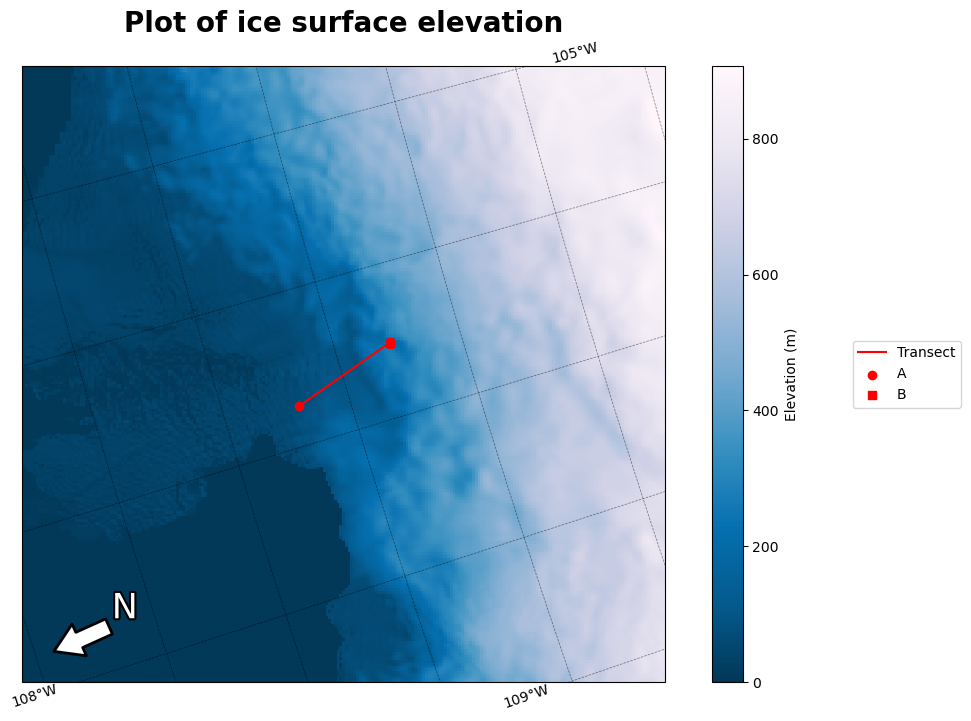

In [9]:
plot_transect_elevation(transect_A, transect_B, surrounding_data)

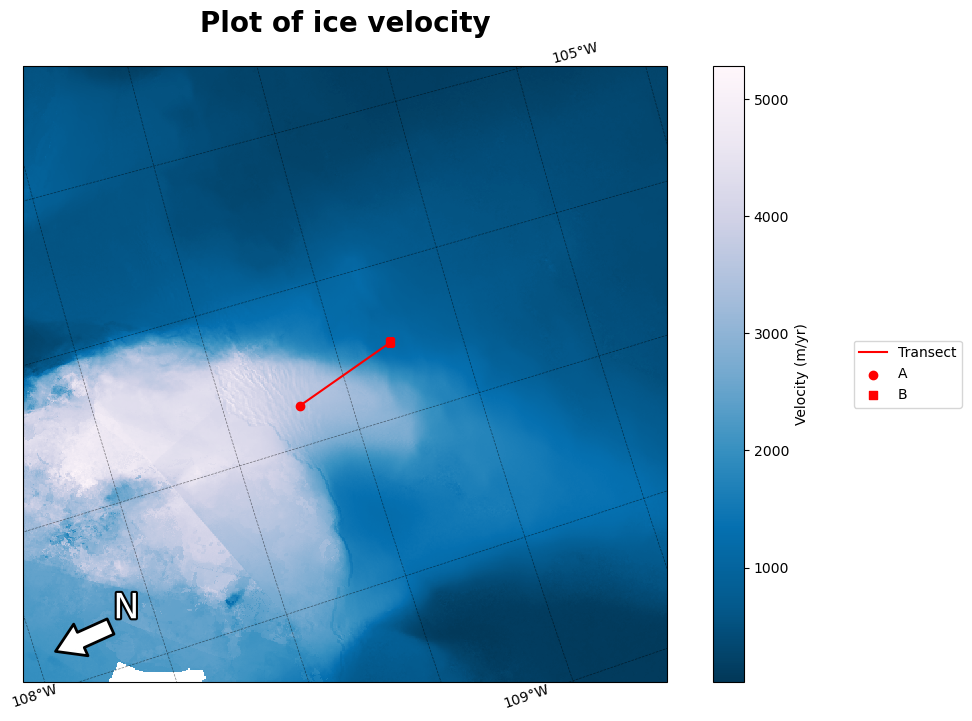

In [10]:
plot_transect_velocity(transect_A, transect_B, surrounding_vel_data)

In [11]:
# fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', draw_labels=True, alpha=0.5, linestyle='--')

# ax.xlabels_top = False
# ax.ylabels_left = True
# ax.ylabels_right= False

# transect_xmax = transect_B[0] + 5.0e5
# transect_xmin = transect_A[0] - 5.0e5
# transect_ymax = transect_B[1] + 5.0e5
# transect_ymin = transect_A[1] - 5.0e5

# big_map = xarray_dataset.where((xarray_dataset['x'] < transect_xmax) & (xarray_dataset['x'] > transect_xmin) & (xarray_dataset['y'] < transect_ymax) & (xarray_dataset['y'] > transect_ymin), drop=True)

# colour_bar_fig = ax.pcolormesh(big_map.x, big_map.y, big_map.surface, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())
# ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r', label='Transect')
# ax.scatter([transect_A[0]], [transect_A[1]], marker='o', color='r', label='A')
# ax.scatter([transect_B[0]], [transect_B[1]], marker='s', color='r', label='B')
# ax.legend(loc='center left', bbox_to_anchor=(1.28, 0.5))

# plt.colorbar(colour_bar_fig, pad=0.05, label='Elevation (m)')
# ax.annotate('N', xy=(0.05, 0.05), xytext=(0.16, 0.12), arrowprops=dict(facecolor='white', edgecolor='black', linewidth=2, width=12, headwidth=25, headlength=20),
#                 ha='center', va='center', fontsize=25, color='white', xycoords='axes fraction', path_effects=[withStroke(linewidth=3, foreground='black')])

# ax.set_title('Plot of ice surface elevation', fontdict={'fontsize': 20, 'fontweight': 'bold'})

# plt.show()

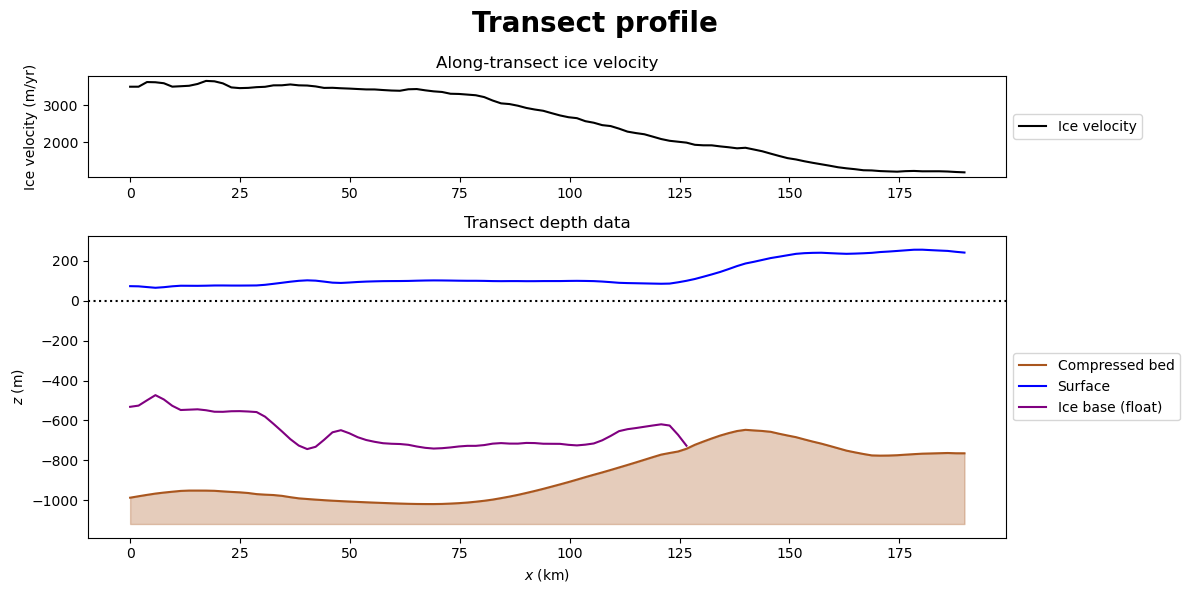

In [12]:
plot_transect_profile(transect_df)

In [13]:
interp = np.zeros_like(transect_df['Floatation']) * np.nan
idx_start = 10
quiet = False
force_balance_flag = False
fig_freq = 1

# Outer_profile_solver(transect_df['Distance'], transect_df['Surface'], transect_df['Bed'], transect_df['Floatation'], interp, transect_df['Velocity'], idx_start,fig_freq, quiet, force_balance_flag)

In [14]:

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})

# cf = ax.pcolormesh(surrounding_vel_data.x, surrounding_vel_data.y, surrounding_vel_data.v, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())
# fig.colorbar(cf)
# ax.axvline(-1.4e6)
# ax.axhline(-6.2e5)

# plt.show()

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})

# ax.pcolormesh(surrounding_data.x, surrounding_data.y, surrounding_data.surface, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())

# ax.plot([transect_A_range[0], transect_B_range[0]], [transect_A_range[1], transect_B_range[1]], c='r')
# ax.set_title('Surface elevation')

# plt.show()


# import cartopy.crs as ccrs
# from matplotlib.patheffects import withStroke


# transect_xmax = transect_B[0] + 5.0e5
# transect_xmin = transect_A[0] - 5.0e5
# transect_ymax = transect_B[1] + 5.0e5
# transect_ymin = transect_A[1] - 5.0e5

# map_extent = [transect_xmax, transect_ymax, transect_xmin, transect_ymin]

# fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', 
#     draw_labels=True, alpha=0.5, linestyle='--')

# ax.xlabels_top = False
# ax.ylabels_left = True
# ax.ylabels_right= False

# colour_bar_fig = ax.pcolormesh(surrounding_data.x, surrounding_data.y, surrounding_data.surface, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())
# ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r', label='Transect')
# ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

# plt.colorbar(colour_bar_fig, pad=0.05, label='Elevation (m)')
# ax.annotate('S', xy=(0.16, 0.15), xytext=(0.05, 0.05), arrowprops=dict(facecolor='white', edgecolor='black', linewidth=2, width=12, headwidth=25, headlength=20),
#                 ha='center', va='center', fontsize=25, color='white', xycoords='axes fraction', path_effects=[withStroke(linewidth=3, foreground='black')])

# ax.set_title('Plot of ice surface elevation', fontdict={'fontsize': 20, 'fontweight': 'bold'})

# plt.show()

# fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', draw_labels=True, alpha=0.5, linestyle='--')

# ax.xlabels_top = False
# ax.ylabels_left = True
# ax.ylabels_right= False

# colour_bar_fig = ax.pcolormesh(surrounding_vel_data.x, surrounding_vel_data.y, surrounding_vel_data.v, cmap='Blues', transform=ccrs.SouthPolarStereo())
# ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r', label='Transect')
# ax.scatter([-1568411.705464], [-435450.421578], c='r', label='Thwaites')

# ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

# plt.colorbar(colour_bar_fig, pad=0.05, label='Velocity (m/yr)')
# ax.annotate('S', xy=(0.16, 0.15), xytext=(0.05, 0.05), arrowprops=dict(facecolor='white', edgecolor='black', linewidth=2, width=12, headwidth=25, headlength=20),
#                 ha='center', va='center', fontsize=25, color='white', xycoords='axes fraction', path_effects=[withStroke(linewidth=3, foreground='black')])

# ax.set_title('Plot of ice velocity', fontdict={'fontsize': 20, 'fontweight': 'bold'})

# plt.show()

In [15]:
# from scipy.interpolate import RegularGridInterpolator

# # Define the interpolator for the original velocity data
# velocity_interpolated = RegularGridInterpolator(
#     (surrounding_vel_data.y, surrounding_vel_data.x),
#     surrounding_vel_data['v'].values,
#     bounds_error=False,
#     fill_value=None
# )




In [16]:
# # transect_distance = (np.sqrt(transect_xarray[0]**2 + transect_yarray[0]**2) - np.sqrt(transect_xarray**2 + transect_yarray**2))/1000

# transect_velocity = velocity_interpolated([-6.2e5, -1.4e6])
# print(transect_velocity)

In [17]:
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})

# ax.pcolormesh(surrounding_data.x, surrounding_data.y, surrounding_data.surface, cmap='PuBu_r', transform=ccrs.SouthPolarStereo())

# ax.plot([transect_A[0], transect_B[0]], [transect_A[1], transect_B[1]], c='r')
# # ax.pcolormesh(xarray_vel_dataset.x, xarray_vel_dataset.y, xarray_vel_dataset['v'], cmap='RdBu', transform=ccrs.SouthPolarStereo())


# plt.show()

# Extra Code

## Save profile

In [18]:
# f = open("new_transect_data", "w")
# f.write(f'Distance\n {test_transect_distance}\n')
# f.write(f'Surface\n {test_interpolated_surface_transect}\n')
# f.write(f'Bed\n {test_interpolated_bed_transect}\n')
# f.write(f'Floatation\n {test_interpolated_float_transect}\n')
# f.close()